# Tarea Final - Herramientas Computacionales

Presentado por: *Brayan Santiago Amorocho Lizcano (2210719)*

In [1]:
#Importamos algunas librerías importantes
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sci
from scipy.optimize import curve_fit
from mpl_toolkits import mplot3d
import matplotlib as mpl

In [2]:
#Lectura de datos. Los datos están en la carpeta del repositorio ;)

GAP_read =pd.read_csv("../data/Global_active_power.csv")
GI_read =pd.read_csv("../data/Global_intensity.csv")
GRP_read =pd.read_csv("../data/Global_reactive_power.csv")
VO_read =pd.read_csv("../data/Voltage.csv")



Una vez leídos los archivos, procedemos a concatenar:

In [3]:
data1 = pd.merge(GAP_read,GI_read, on=["Datetime"])
data2 = pd.merge(GRP_read,VO_read, on=["Datetime"])
data = pd.merge(data1,data2, on=["Datetime"])


#Ahora convertimos los datos a vatios/hora
data["Global_active_power"] = round(data["Global_active_power"]*1000/60, 3)
data["Global_reactive_power"] = round(data["Global_reactive_power"]*1000/60, 3)
data


,Datetime,Global_active_power,Global_intensity,Global_reactive_power,Voltage
0,2010-01-01 00:00:00,29.833,7.4,3.933,240.65
1,2010-01-01 00:01:00,29.667,7.4,3.900,240.07
2,2010-01-01 00:02:00,29.667,7.4,3.900,240.15
3,2010-01-01 00:03:00,29.100,7.2,3.100,240.26
4,2010-01-01 00:04:00,28.100,7.0,1.700,240.12
...,...,...,...,...,...
457390,2010-11-26 20:58:00,15.767,4.0,0.000,240.43
457391,2010-11-26 20:59:00,15.733,4.0,0.000,240.00
457392,2010-11-26 21:00:00,15.633,3.8,0.000,239.82
457393,2010-11-26 21:01:00,15.567,3.8,0.000,239.70


Antes de hacer el resample, es necesario ajustar el Datetime para que Pandas no nos ponga problemas

In [4]:
data["Datetime"]=pd.to_datetime(data["Datetime"])
data= data.set_index("Datetime")
#Básicamente cambiamos la forma de la columna "Datetime" (Que era tipo Object) a una que Pandas pueda leer y convertir ;)
data

,Global_active_power,Global_intensity,Global_reactive_power,Voltage
Datetime,,,,
2010-01-01 00:00:00,29.833,7.4,3.933,240.65
2010-01-01 00:01:00,29.667,7.4,3.900,240.07
2010-01-01 00:02:00,29.667,7.4,3.900,240.15
2010-01-01 00:03:00,29.100,7.2,3.100,240.26
2010-01-01 00:04:00,28.100,7.0,1.700,240.12
...,...,...,...,...
2010-11-26 20:58:00,15.767,4.0,0.000,240.43
2010-11-26 20:59:00,15.733,4.0,0.000,240.00
2010-11-26 21:00:00,15.633,3.8,0.000,239.82


Ahora procedemos a hacer el *resample*.

In [5]:
#En días
data_d = data.resample("D").mean()

#Revisamos que no haya algún infinito o 0 que dañe los resultados:
data_d.replace([np.inf, -np.inf, 0], np.nan, inplace=True)
data_d.dropna(inplace=True) 
#Pd: Lo hago solo con este pq en el de los meses se puede ver que de por sí no hay vacíos o NaN

data_d

,Global_active_power,Global_intensity,Global_reactive_power,Voltage
Datetime,,,,
2010-01-01,14.169592,3.537083,1.913614,242.565722
2010-01-02,19.603921,4.857778,1.444256,243.631743
2010-01-03,15.031576,3.757778,1.505511,241.822778
2010-01-04,19.530563,4.879028,1.672035,241.754160
2010-01-05,15.279607,3.929861,2.228298,240.647167
...,...,...,...,...
2010-12-07,12.842301,3.397222,3.309176,240.218646
2010-12-08,6.130765,1.623750,1.957152,240.794931
2010-12-09,18.658474,4.755694,2.330551,241.619722


In [6]:
#En meses
data_m = data.resample("M").mean()
data_m

,Global_active_power,Global_intensity,Global_reactive_power,Voltage
Datetime,,,,
2010-01-31,21.677334,5.430332,2.086377,242.338522
2010-02-28,19.292318,4.836624,1.824457,242.002101
2010-03-31,19.500255,4.920399,2.272798,241.475284
2010-04-30,17.272230,4.363496,2.159279,241.442527
2010-05-31,17.932618,4.551504,2.120356,241.296151
2010-06-30,16.255105,4.170282,2.425415,240.888985
2010-07-31,12.982458,3.337202,2.301545,240.965167
2010-08-31,15.490872,3.954423,2.180260,241.422944
2010-09-30,16.625685,4.223837,2.128339,241.267517


# Modelo de regresión

Antes de empezar con los modelos de regresión, inserté algunas funciones que nos ayudarán a establecer las relaciones.


In [7]:
#Funciones que usaremos en curvefit
def lineal(x, m, b):
    return m*x+b
def compuesta(X,a1,a2,b):
    x,y = X
    return a1*x+a2*y+b

In [8]:
#También añadiremos fuentes bonitas para las gráficas ;)
font = {"family" : "serif",
        "color"  : "darkred",
        "weight" : "bold",
        "size"   : 16,
        }

font2 = {"family" : "serif",
         "color"  : "black",
         "weight" : "bold",
         "size"   : 12,
        }

**1**. Relación entre Global_Active_Power (GAP) y Global Intensity (GI).

$GAP = A_{1}GI+B_{1} $

Para hacerlo más sencillo, es como decir
$y = f(x) = mx+b $, por lo tanto, es correcto decir que la GAP depende de la GI.

In [9]:
#Encontramos los coeficientes:
#Por minutos
popt1, pcov1 = curve_fit(lineal, data["Global_intensity"],data["Global_active_power"])
#Por días
popt1_d, pcov1_d = curve_fit(lineal, data_d["Global_intensity"],data_d["Global_active_power"])
#Por meses
popt1_m, pcov1_m = curve_fit(lineal, data_m["Global_intensity"],data_m["Global_active_power"])


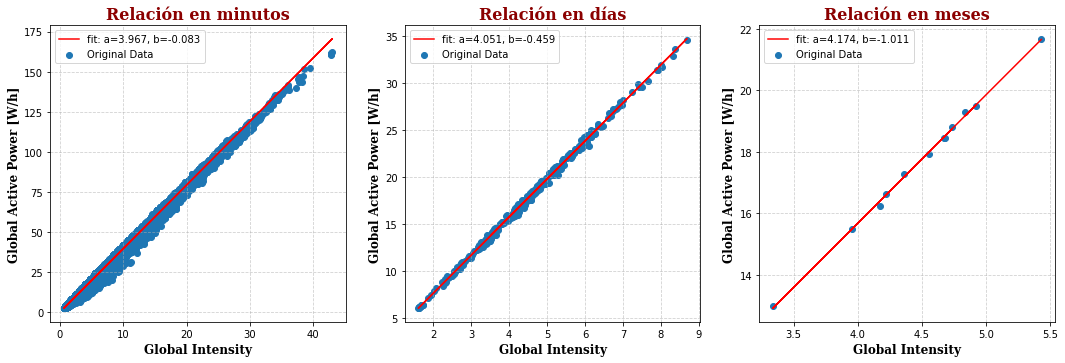

In [10]:
#Graficamos las relaciones para cada resample:

plt.figure(figsize=(18,12)) #Lo pongo así para mostrar las tres gráficas en un renglón ;)
#Gráfica de minutos
ax1 = plt.subplot(231)
plt.plot(data["Global_intensity"], lineal(data["Global_intensity"],*popt1),"r-", label="fit: a=%5.3f, b=%5.3f" %tuple(popt1))
plt.scatter(data["Global_intensity"],data["Global_active_power"], label = "Original Data")
ax1.set_title("Relación en minutos", fontdict = font)
ax1.set_xlabel("Global Intensity", fontdict = font2)
ax1.set_ylabel("Global Active Power [W/h]", fontdict = font2)
plt.legend()
plt.grid(linestyle="--", alpha =0.6)

#Gráfica de días
ax1 = plt.subplot(232)
plt.plot(data_d["Global_intensity"], lineal(data_d["Global_intensity"],*popt1_d),"r-", label="fit: a=%5.3f, b=%5.3f" %tuple(popt1_d))
plt.scatter(data_d["Global_intensity"],data_d["Global_active_power"], label = "Original Data")
ax1.set_title("Relación en días", fontdict = font)
ax1.set_xlabel("Global Intensity", fontdict = font2)
ax1.set_ylabel("Global Active Power [W/h]", fontdict = font2)
plt.legend()
plt.grid(linestyle="--", alpha =0.6)

#En meses
ax1 = plt.subplot(233)
plt.plot(data_m["Global_intensity"], lineal(data_m["Global_intensity"],*popt1_m),"r-", label="fit: a=%5.3f, b=%5.3f" %tuple(popt1_m))
plt.scatter(data_m["Global_intensity"],data_m["Global_active_power"], label = "Original Data")
ax1.set_title("Relación en meses", fontdict = font)
ax1.set_xlabel("Global Intensity", fontdict = font2)
ax1.set_ylabel("Global Active Power [W/h]", fontdict = font2)
plt.legend()
plt.grid(linestyle="--", alpha =0.6)

plt.show()

Sin embargo, aún no sabemos cuál podría ser el modelo más apropiado. Por lo tanto, calculamos el errror. Además, imprimimos los valores de $A_{1} y b_{1}$ junto con su margen de error.

In [11]:
#Calculando el error: 
def get_fit(func, xdata, ydata, r):
    popt, pcov = curve_fit(func, xdata, ydata)
    popt, cov = np.around(popt,r), np.around(np.sqrt(np.diag(pcov)),r)
    Error = np.sqrt(np.mean((ydata-func(xdata,*popt))**2))
    Error = np.around(Error,r)
    print("Los coeficientes son: {}".format(popt))
    print("El margen de error (sigma) de los coeficientes son: {}, respectivamente.".format(cov))
    print("El error es de: {}".format(Error))
    #Calculando el coeficiente de Pearson

    def pearson(a,dev):
        return dev / a * 100
    if len(popt)==2:
        print("El número de pearson en m1 es de: %2.5f, y en b1 de: %2.5f." % tuple(pearson(popt,cov)))
    if len(popt)==3:
        print("El número de pearson en a1 es de: %2.5f, en a2 es de: %2.5f, y en b1 de: %2.5f." % tuple(pearson(popt,cov)))
    

In [12]:
print("Trabajando con los datos por minuto:")
get_fit(lineal,data["Global_intensity"],data["Global_active_power"],4)

Trabajando con los datos por minuto:
Los coeficientes son: [ 3.9671 -0.083 ]
El margen de error (sigma) de los coeficientes son: [0.0003 0.0018], respectivamente.
El error es de: 0.8209
El número de pearson en m1 es de: 0.00756, y en b1 de: -2.16867.


In [13]:
print("Trabajando con los datos por día:")
get_fit(lineal,data_d["Global_intensity"],data_d["Global_active_power"],4)

Trabajando con los datos por día:
Los coeficientes son: [ 4.051  -0.4589]
El margen de error (sigma) de los coeficientes son: [0.01  0.047], respectivamente.
El error es de: 0.2537
El número de pearson en m1 es de: 0.24685, y en b1 de: -10.24188.


In [14]:
print("Trabajando con los datos por mes:")
get_fit(lineal,data_m["Global_intensity"],data_m["Global_active_power"],4)

Trabajando con los datos por mes:
Los coeficientes son: [ 4.1738 -1.0112]
El margen de error (sigma) de los coeficientes son: [0.0426 0.1925], respectivamente.
El error es de: 0.0688
El número de pearson en m1 es de: 1.02065, y en b1 de: -19.03679.


**2**. Relación entre Global_Active_Power (GAP) y Voltage (VO).

$GAP = A_{2}VO+B_{2} $



In [15]:
#Encontramos los coeficientes:
#Por minutos
popt2, pcov2 = curve_fit(lineal, data["Voltage"],data["Global_active_power"])
#Por días
popt2_d, pcov2_d = curve_fit(lineal, data_d["Voltage"],data_d["Global_active_power"])
#Por meses
popt2_m, pcov2_m = curve_fit(lineal, data_m["Voltage"],data_m["Global_active_power"])


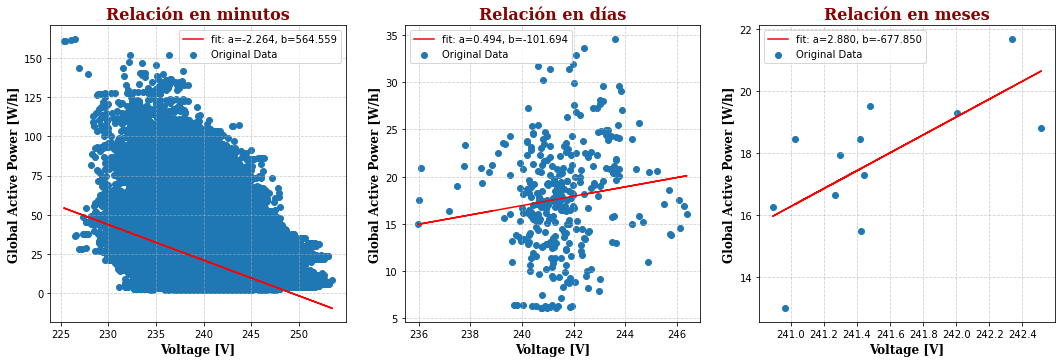

In [16]:
#Graficamos las relaciones para cada resample:

plt.figure(figsize=(18,12)) #Lo pongo así para mostrar las tres gráficas en un renglón ;)
#Gráfica de minutos
ax1 = plt.subplot(231)
plt.plot(data["Voltage"], lineal(data["Voltage"],*popt2),"r-", label="fit: a=%5.3f, b=%5.3f" %tuple(popt2))
plt.scatter(data["Voltage"],data["Global_active_power"], label = "Original Data")
ax1.set_title("Relación en minutos", fontdict = font)
ax1.set_xlabel("Voltage [V]", fontdict = font2)
ax1.set_ylabel("Global Active Power [W/h]", fontdict = font2)
plt.legend()
plt.grid(linestyle="--", alpha =0.6)

#Gráfica de días
ax1 = plt.subplot(232)
plt.plot(data_d["Voltage"], lineal(data_d["Voltage"],*popt2_d),"r-", label="fit: a=%5.3f, b=%5.3f" %tuple(popt2_d))
plt.scatter(data_d["Voltage"],data_d["Global_active_power"], label = "Original Data")
ax1.set_title("Relación en días", fontdict = font)
ax1.set_xlabel("Voltage [V]", fontdict = font2)
ax1.set_ylabel("Global Active Power [W/h]", fontdict = font2)
plt.legend()
plt.grid(linestyle="--", alpha =0.6)

#En meses
ax1 = plt.subplot(233)
plt.plot(data_m["Voltage"], lineal(data_m["Voltage"],*popt2_m),"r-", label="fit: a=%5.3f, b=%5.3f" %tuple(popt2_m))
plt.scatter(data_m["Voltage"],data_m["Global_active_power"], label = "Original Data")
ax1.set_title("Relación en meses", fontdict = font)
ax1.set_xlabel("Voltage [V]", fontdict = font2)
ax1.set_ylabel("Global Active Power [W/h]", fontdict = font2)
plt.legend()
plt.grid(linestyle="--", alpha =0.6)

plt.show()

Ahora imprimamos los coeficientes y el error de cada gráfica:

In [17]:
#Por minuto.
print("Trabajando con los datos por minuto:")
get_fit(lineal,data["Voltage"],data["Global_active_power"],4)

Trabajando con los datos por minuto:
Los coeficientes son: [ -2.2643 564.5588]
El margen de error (sigma) de los coeficientes son: [0.0073 1.772 ], respectivamente.
El error es de: 14.1466
El número de pearson en m1 es de: -0.32240, y en b1 de: 0.31387.


In [18]:
#Por días.
print("Trabajando con los datos por día:")
get_fit(lineal,data_d["Voltage"],data_d["Global_active_power"],4)

Trabajando con los datos por día:
Los coeficientes son: [   0.4943 -101.6942]
El margen de error (sigma) de los coeficientes son: [ 0.2063 49.8228], respectivamente.
El error es de: 5.6881
El número de pearson en m1 es de: 41.73579, y en b1 de: -48.99276.


In [19]:
#Por meses.
print("Trabajando con los datos por mes:")
get_fit(lineal,data_m["Voltage"],data_m["Global_active_power"],4)

Trabajando con los datos por mes:
Los coeficientes son: [   2.8802 -677.8497]
El margen de error (sigma) de los coeficientes son: [  0.9992 241.3043], respectivamente.
El error es de: 1.5754
El número de pearson en m1 es de: 34.69204, y en b1 de: -35.59850.


**3**. Relación entre Global_Active_Power (GAP), Global Intensity (GI) y Voltage (VO).

$GAP = A_{31}GI+ A_{32}VO + B_{3} $

Este caso es algo más complicado, puesto que combina dos variables. Pero de igual forma, gracias a las relaciones obtenidas anteriormente es posible dar con los coeficientes. Además, hay que tener en cuenta que la gráfica estará en $R^{3}$

In [20]:
popt3, pcov3 = curve_fit(compuesta, (data["Global_intensity"], data["Voltage"]), data["Global_active_power"])
popt3_d, pcov3_d = curve_fit(compuesta, (data_d["Global_intensity"], data_d["Voltage"]), data_d["Global_active_power"])
popt3_m, pcov3_m = curve_fit(compuesta, (data_m["Global_intensity"], data_m["Voltage"]), data_m["Global_active_power"])

Como estamos trabajando en una gráfica en tres dimensiones, debemos fijar los valores del plano que ajustará cada set de datos a partir relacionando las variables independientes con la dependiente:

In [21]:
# En resumidas cuentas, estamos creando un array con mínimos, máximos.
min_GI = [np.min(data["Global_intensity"]), np.max(data["Global_intensity"]),(int(len(data["Global_intensity"])/1000))]
min_Vo = [np.min(data["Voltage"]), np.max(data["Voltage"]),(int(len(data["Voltage"])/1000))]

d_GI = [np.min(data_d["Global_intensity"]), np.max(data_d["Global_intensity"]),(len(data_d["Global_intensity"]))]
d_Vo = [np.min(data_d["Voltage"]), np.max(data_d["Voltage"]),len(data_d["Voltage"])]

m_GI = [np.min(data_m["Global_intensity"]), np.max(data_m["Global_intensity"]),len(data_m["Global_intensity"])]
m_Vo = [np.min(data_m["Voltage"]), np.max(data_m["Voltage"]),len(data_m["Voltage"])]


Ahora podemos graficar cada conjunto de datos con su respectivo ajuste.

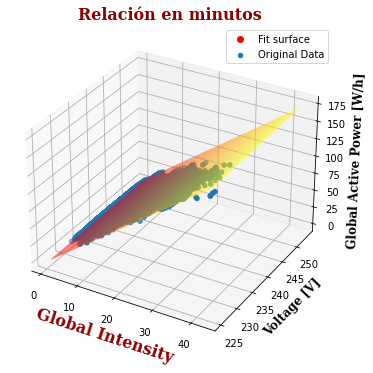

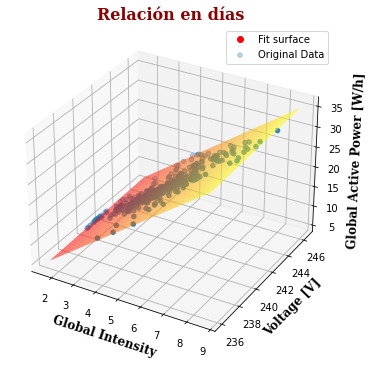

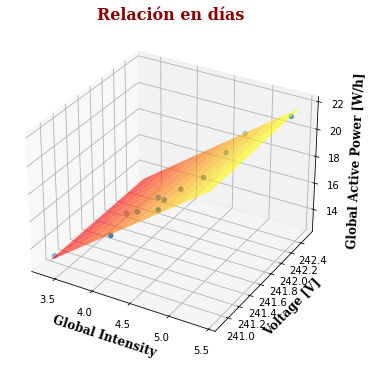

In [22]:
#Como tenemos dos variables, la gráfica nos dará en tres dimensiones:

#Primero hacemos la gráfica de los datos originales
plt.figure(figsize=(8,6))
ax  = plt.axes(projection="3d")
x   = np.linspace(*min_GI)
y   = np.linspace(*min_Vo) #Para esto era necesario encontrar los arrays anteriores ;)
xx, yy = np.meshgrid(x,y)
z = compuesta((xx,yy),*popt3)
scatter = ax.scatter3D(data["Global_intensity"],data["Voltage"],data["Global_active_power"])
ax.plot_surface(xx,yy,z,alpha=0.6,cmap="autumn") #Acá graficamos el plano
ax.set_title("Relación en minutos", fontdict = font)
ax.set_xlabel("Global Intensity", fontdict = font)
ax.set_ylabel("Voltage [V]", fontdict = font2)
ax.set_zlabel("Global Active Power [W/h]", fontdict = font2)
legends = mpl.lines.Line2D([0],[0], linestyle="none", color='r', marker = 'o')
ax.legend([legends,scatter],["Fit surface", "Original Data"], numpoints = 1)
plt.show() 

plt.figure(figsize=(8,6))
ax2  = plt.axes(projection="3d")
x2   = np.linspace(*d_GI)
y2   = np.linspace(*d_Vo) 
xx2, yy2 = np.meshgrid(x2,y2)
z2 = compuesta((xx2,yy2),*popt3_d)
ax2.scatter3D(data_d["Global_intensity"],data_d["Voltage"],data_d["Global_active_power"])
ax2.plot_surface(xx2,yy2,z2,alpha=0.6,cmap="autumn") #Acá graficamos el plano
ax2.set_title("Relación en días", fontdict = font)
ax2.set_xlabel("Global Intensity", fontdict = font2)
ax2.set_ylabel("Voltage [V]", fontdict = font2)
ax2.set_zlabel("Global Active Power [W/h]", fontdict = font2)
legends = mpl.lines.Line2D([0],[0], linestyle="none", color='r', marker = 'o')
ax2.legend([legends,scatter],["Fit surface", "Original Data"], numpoints = 1)
plt.show() 

plt.figure(figsize=(8,6))
ax3  = plt.axes(projection="3d")
x3   = np.linspace(*m_GI)
y3   = np.linspace(*m_Vo) 
xx3, yy3 = np.meshgrid(x3,y3)
z3 = compuesta((xx3,yy3),*popt3_m)
ax3.scatter3D(data_m["Global_intensity"],data_m["Voltage"],data_m["Global_active_power"])
ax3.plot_surface(xx3,yy3,z3,alpha=0.6,cmap="autumn") #Acá graficamos el plano
ax3.set_title("Relación en días", fontdict = font)
ax3.set_xlabel("Global Intensity", fontdict = font2)
ax3.set_ylabel("Voltage [V]", fontdict=font2)
ax3.set_zlabel("Global Active Power [W/h]", fontdict = font2)
legends = mpl.lines.Line2D([0],[0], linestyle="none", color='r', marker = 'o')
ax2.legend([legends,scatter],["Fit surface", "Original Data"], numpoints = 1)
plt.show() 

In [23]:
#Ahora obtenemos los datos de error y los parámetros:
print("Trabajando con los datos por minuto:")
get_fit(compuesta,(data["Global_intensity"],data["Voltage"]),data["Global_active_power"],5)


Trabajando con los datos por minuto:
Los coeficientes son: [  3.99133   0.07782 -18.98635]
El margen de error (sigma) de los coeficientes son: [0.00033 0.00046 0.11094], respectivamente.
El error es de: 0.79603
El número de pearson en a1 es de: 0.00827, en a2 es de: 0.59111, y en b1 de: -0.58431.


In [24]:
print("Trabajando con los datos por día:")
get_fit(compuesta,(data_d["Global_intensity"],data_d["Voltage"]),data_d["Global_active_power"],5)


Trabajando con los datos por día:
Los coeficientes son: [  4.03917   0.10288 -25.2543 ]
El margen de error (sigma) de los coeficientes son: [0.0079  0.00727 1.75205], respectivamente.
El error es de: 0.19898
El número de pearson en a1 es de: 0.19558, en a2 es de: 7.06649, y en b1 de: -6.93763.


In [25]:
print("Trabajando con los datos por mes:")
get_fit(compuesta,(data_m["Global_intensity"],data_m["Voltage"]),data_m["Global_active_power"],5)


Trabajando con los datos por mes:
Los coeficientes son: [  4.0875    0.13469 -33.15143]
El margen de error (sigma) de los coeficientes son: [0.04021 0.04116 9.8236 ], respectivamente.
El error es de: 0.04647
El número de pearson en a1 es de: 0.98373, en a2 es de: 30.55906, y en b1 de: -29.63251.


# Conclusiones

A continuación se presentan los errores en los ajustes de cada relación y sus diferentes *resamples*.

| **Relación \ Tipo de datos** | **Minutos** |  **Días** | **Meses** |
| :- | :- | :- | :- |
| **1. Global Intensity vs Global Active Power.**  | 0.8209 | 0.2537  | 0.0688  | 
|  **2. Voltage vs Global Active Power.** | 14.1466  | 5.6881 |  1.5753  | 
|  **3. Global Intensity + Voltage vs Global Active Power.** | 0.796  | 0.1989  | 0.04647 | 

Como podemos observar, la relación más acertada es la número 3. Puesto que presenta un error más bajo. Sin embargo, la relación 1 no se queda atrás y también presenta un error considerablemente bajo. Por lo que es correcto decir que ambas relaciones son acertadas. 
Por otra parte, la relación menos acertada es la número 2. Que relaciona el Voltaje con el *Global Active power*, podemos decir que estas dos no tienen ninguna relación dado el error tan alto que se presenta.
Finalmente, queda decir que los errores más bajos se presentaron cuando se estaba trabajando con los datos en meses. Esto tiene sentido, puesto que al haber menos datos es menos probable que alguno no concuerde con el modelo. Si miramos las gráficas de los minutos, nos damos cuenta que, como son muchos datos, es casi imposible dar con un resultado con un margen de error tan bajo como el presentado al trabajar con meses.